# Part 2 and 3 (coding)
* This is Part 2 and 3 (the coding sections) of HW_01
* From Quinn Hull (Robert Hull)

# Outline:

## 2.Linear and Quadratic Classifiers
###     * 2a. General Function for Random Samples
###     * 2b. Procedure of the discriminant
###     * 2c. 2D dataset with three classes and quadratic classifier
###     * 2d. Mahalanobis Distance:
###     * 2e. Naive Bayes Classifier
## 3. Miscellaneous Code 
###     * Problem II (Sampling from a Distribution)

In [1]:
### modules used in the below
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from numpy.linalg import inv
import numpy as np
from numpy.linalg import det
from numpy.linalg import inv
from scipy.spatial import distance 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB

### 2a. General Function for Random Samples
* The code below generates random samples in d dimensions given a 1-D matrix of means and 2-D matrix of covariance that could conceivably be any real number
* It allows the user to flexibly implement whether or not to set the parameters needed to make this distribution or not

In [2]:

# *NOTE What is covariance matrix, really?
def randomsamples(d, size, up=1, down=-1, u=False, sig=False, condin = True, retall = False):
    """A function to generate random samples
        inputs: 
        d -> dimensions (int)
        size -> the size of the sample desired
        up -> the max of range of numbers to generate random 
            (default 1) 
        down -> the min of range of numbers to generate random
            (default -1)
        u -> optional input mean, a vector of size d
            (if not added, script will generate randomly)
        sig -> optional input covariance matrix, a matrix 
            of dimensions d*d
            (if not added, script will generate randomly)
        condin -> conditional independence boolean
            if True (default) then off-diagonal 
            values of sigma are zero
            if False, then any values in sigma
            may be a real number
        retall -> boolean for returning u and sigma
            True -> returns distribution, u, sig
            False -> returns distribution
            (default False)
        

        returns: 
        a multivariate matrix sample with gaussian distribution    
        
        and optionally u and sig
        """

    if u is False:
        ## means of dimensions 'd' [0, 1)
        u = np.random.uniform(down, up, size=(d,))
    
    if sig is False:
        ## covariance matrix of dimension 'd*d' [0,1)
        sig = np.random.uniform(down, up, size=(d,d))
        ## test for conditional independence
        if condin:
            sig = sig*np.identity(d)

    if retall:
        return np.random.multivariate_normal(u, sig, size).T, u, sig

    else:
        return np.random.multivariate_normal(u, sig, size).T

the mean vector is,  [1.96621271 0.92672853]
the covariance matrix is,  
 [[-0.03377318  0.        ]
 [ 0.          0.33247858]]
<ipython-input-2-ce2ff57db36f>:45: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(u, sig, size).T, u, sig


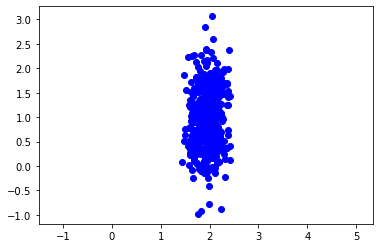

In [3]:
# returns a 2 dimensional randomly created variable and mean and covariances from population too!
d_r = 2 # dimensions
x_r, u_r, sig_r = randomsamples(2,500,d_r, retall=True) # returns information about the population
print('the mean vector is, ', u_r)
print('the covariance matrix is, ', '\n', sig_r)
plt.plot(x_r[0], x_r[1], 'o', c='b')
plt.axis('equal')
plt.show()

### 2b. Procedure of the discriminant
* Although `skLearn` has a helpful library of discriminant related classifier analyses (like quadratic), I couldn't see a function to calculate the discriminant itself (gcx). 
* The script below generates a procedure for calculating the discriminant, which is used later in the quadratic classifer problem
* Note also that this assumes that the distributional information about the sample are already known.

In [4]:
def discriminant(x, u, sig, pc, d, retall = False):
    """A procedure for calculating the discriminant
        function from a given:

        x -> values 
        u -> means 
        sig -> covariance 
        pc -> prior probability of c 
        d -> dimensions 
        retall -> option to return spatial info for randomly
            created data
            (default False)

        returns:
        g(x) for a given class c (the discriminant)
        
        also returns all of the distributional data used to make calc
        (x, u, sig, pc) if retall=True
    """

    # calculate x - u
    xu = np.mat(x - u)
    # determinant of sigma
    detsig = det(sig) 
    # inverse of sigma 
    invsig = np.mat(inv(sig))


    # discriminant fnction
    gx = -0.5*xu*invsig*xu.T \
          - d/2*np.log(2*np.pi) - 1/2*np.log(detsig) \
          + np.log(pc)

    if retall:
        return gx, x, u, sig, pc 

    else:
        return gx


In [5]:
# this procedure calculates the discriminant from first element of randomly generated dataset x_r
# note that as written it only works for individual inputs

# see previous randomly generated dataset
x_in = x_r[:,0] # first sample (w/ elements x_1 and x_2) from x_r

pc_r = np.random.uniform(0,1) # prior probability of rando class, randomly generated

print('x input is ', x_in, 'of shape', x_in.shape)
print('mean input is ', u_r, 'of shape', u_r.shape)
print('sigma input is ', sig_r, 'of shape', sig_r.shape)
print('probability input is ', pc_r, 'of ', type(pc_r), '\n')
print('the discriminant of this randomness is...', discriminant(x=x_in, u=u_r, sig=sig_r, pc=pc_r, d=d_r, retall = False).item())



x input is  [1.58473539 0.50341137] of shape (2,)
mean input is  [1.96621271 0.92672853] of shape (2,)
sigma input is  [[-0.03377318  0.        ]
 [ 0.          0.33247858]] of shape (2, 2)
probability input is  0.24357236785048386 of  <class 'float'> 

the discriminant of this randomness is... nan
<ipython-input-4-45fa54295979>:31: RuntimeWarning: invalid value encountered in log
  - d/2*np.log(2*np.pi) - 1/2*np.log(detsig) \


### 2c. 2D dataset with three classes and quadratic classifier
* The script is broken into several sections
    1. Generate three classes of random variables, 'learns' the distributional information from the sample, and plots them
    2. Uses the distributional information from the samples to **train** a quadratic classifier and then **test** it on some 2-dimensional test point. This is done using the discriminate function from the previous section, and compared to the dedicated function from `sklearn`
    3. Finally, the `sklearn` predict() function is used to generate decision boundary using a random, uniformly distributed dataset that is plotted as a scatterplot and categorized according to the prediction from the classifier

<ipython-input-2-ce2ff57db36f>:45: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(u, sig, size).T, u, sig


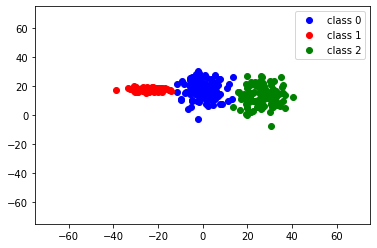

In [6]:
# A. generate 3 random variables and plot (will be used for the rest of this)

# 1. globals 
d = 2 # dimensions
k = 100 # size of input
n = 15 # size of test subset
class_num = 3 # number of classes
up_in = 50 # upper bound of input data
down_in = -50 # lower bound of input data

# 2. create bivariate gaussian data with 3 known classes, that are conditionally independent! 
x_1, u_true1, sig_true1 = randomsamples(d,k,up=50,down=-50,retall=True)
x_2, u_true2, sig_true2 = randomsamples(d,k,up=50,down=-50,retall=True)
x_3, u_true3, sig_true3 = randomsamples(d,k,up=50,down=-50,retall=True)
x_train_list = [x_1, x_2, x_3]

# 3. reserve some as a test set (n number)
x_1_train, x_1_test = x_1[:,0:-n], x_1[:,-n:]
x_2_train, x_2_test = x_2[:,0:-n], x_2[:,-n:]
x_3_train, x_3_test = x_3[:,0:-n], x_3[:,-n:]
x_test_list = [x_1_test, x_2_test, x_3_test]

# 4. calculate mean and sigma from other (train) set for each of three classes
u_1, u_2, u_3 = np.mean(x_1_train, axis=1), np.mean(x_2_train, axis=1), np.mean(x_3_train,axis=1)
sig_1, sig_2, sig_3 = np.var(x_1_train, axis=1), np.var(x_2_train, axis=1), np.var(x_3_train, axis=1)
u_list = [u_1, u_2, u_3]
sig_list = [sig_1, sig_2, sig_3]

# 5. list containing priors for each class_c
# assume equal priors (because there are the same
#   numbers in each class, they have a 1/c chance
#   of occuring, 1/3)
pri_list = [(1/3), (1/3), (1/3)]

# 6. plot
# color list for graphing
color_list = ['b', 'r', 'g']
for cla in range(class_num):
    plt.plot(x_train_list[cla][0], x_train_list[cla][1], 'o', c=color_list[cla],label="class "+str(cla))

plt.xlim(down_in*1.5, up_in*1.5)
plt.ylim(down_in*1.5, up_in*1.5)
plt.legend()
plt.show()


In [7]:
# B. train and test quadratic classifier, using both custom and sklearn functions

# 1. take a single value from test dataset, from class 0
x_test = x_test_list[0][:,0]

# 2. convert sigs back to dxd
sig_listdd =[]
for sig in sig_list:
    sig_listdd.append(sig*np.identity(sig.shape[0]))


# 3. discriminant analysis tool, custom
disc_list = []
for i in range(class_num):
    disc = discriminant(x=x_test, u=u_list[i], sig=sig_listdd[i],
                        pc=pri_list[i], d=x_test.shape[0]).item()
    disc_list.append(disc)
    del disc

result = np.where(np.array(disc_list) == np.amax(np.array(disc_list)))[0].item()

print('the point is most likely located in class ', result, 'according to custom quadratic classification')

# 4. discriminant analysis tool, sklearn
# *NOTE X and y are used later on in the Naive Baisian Classifer
X = np.concatenate(x_train_list,axis=1).T # training data, predictors
y = np.array([np.full((k),0), np.full((k),1), np.full((k),2)]).flatten() # training data, target
clf = QuadraticDiscriminantAnalysis()
clf.fit(X, y)
result = clf.predict(np.array([x_test])).item()
print('the point is most likely located in class ', result, 'according to sklearn quadratic classification')

the point is most likely located in class  0 according to custom quadratic classification
the point is most likely located in class  0 according to sklearn quadratic classification


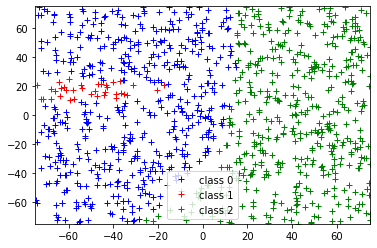

In [8]:
# 3. Create decision boundaries

# predict decision boundaries from randomized 2x2 dataset
# use the sklearn to compare all values in a dataset
x_test_scatter = np.random.uniform(down_in*1.5, up_in*1.5, size=(d,k*10))

# make prediction
pred_scatter = clf.predict(x_test_scatter.T)

# plot
plt.plot(x_test_scatter[0][pred_scatter==0], x_test_scatter[1][pred_scatter==0], '+', c='b', label='class 0')
plt.plot(x_test_scatter[0][pred_scatter==1], x_test_scatter[1][pred_scatter==1], '+', c='r', label='class 1')
plt.plot(x_test_scatter[0][pred_scatter==2], x_test_scatter[1][pred_scatter==2], '+', c='g', label='class 2')

plt.xlim(down_in*1.5, up_in*1.5)
plt.ylim(down_in*1.5, up_in*1.5)
plt.legend()
plt.show()

### 2d. Mahalanobis Distance:
* Two Mahalanobis Distance Equations are explored. The built-in scipy function and a custom one built using numpy arrays, using the mahalanobis equation as described in the scipy function documentation. This includes a square root symbol, which is not the case for the generalized form of the Mahalanobis equation shared in class.

Man - distance, scipy routine
4.167868200213435
Man - distance, custom routine
4.167868200213435


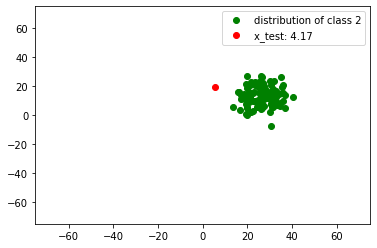

In [9]:
# this procedure takes the distance between a random test point from class 0 and the training set for class 2

# note, using the test data taken from earlier, class 0, a single point
x_test = x_test_list[0][:,0]
# extract average for later
u_train = u_list[2]
# invert sigma for later
sig_train = inv(sig_listdd[2])

# built in routine *NOTE the sqrt of the function you asked us to make
print("Man - distance, scipy routine")
dist = distance.mahalanobis(x_test,u_train,sig_train)
print(dist)

# custom routine *NOTE the sqrt of the function you asked us to make
print("Man - distance, custom routine")
dist_cust = np.sqrt(np.mat(x_test - u_train)*np.mat(sig_train)*np.mat(x_test-u_train).T).item()
print(dist_cust)

# plot
plt.plot(x_train_list[2][0], x_train_list[2][1], 'o', c='g', label='distribution of class 2')
plt.plot(x_test[0], x_test[1], 'o', c='r', label='x_test: '+str(np.round(dist,2)))
plt.xlim(down_in*1.5, up_in*1.5)
plt.ylim(down_in*1.5, up_in*1.5)
plt.legend()
plt.show()

### 2e. Bayes Classifier: 
* given: the posterior probability (P(wj|x)) is proportional to the product of likelihood (P(x|wj)) and prior p(wj)
* assumptions: 
   1. each class has an equal prior (given 100 samples in n=3 categories, prior = 100/300 = 1/3)
   2. the distribution of the likelihood (P(x|wj)) is gaussian, w/ known distribution
      * fx = np.exp(-(1/2)*(x-u)**2/sig^2)/(sig*np.sqrt(2*PI)) (1-D) <-- use this definition, and iterate
      * fx = np.exp(-(1/2)*(x-u).T*sig.inv*(x-u))/(sig*np.sqrt(2*PI)) (2-D)
   3. for a given sample X of dimension i=1 to d, the total likelihood of p(X|wj) is equal to the sum of the log of the individual probabilities x1, x2,..., xd given wj. np.sum(np.log(pxi|wj))
* want: to classify a test dataset into n categories based on which posterior (j=1-n) is highest for a given sample X


In [10]:
# *NOTE given that we assume conditional independence for this, we can assume that off-diagonal values in sigma are zeros, which is critical in order to solve for this problem

# *NOTE this problem uses the data generated in previous steps

# 1. create function p(xi|wj) = fx (univariate probability classifier)
def fx(xi, uj, sj):
    return np.exp(-(1/2)*(xi-uj)**2/sj**2)/(sj*np.sqrt(2*np.pi))

# 2. calculate fx (prior) from mean and sigma for e/a class and dimension on all test data, taking care to respect assumtion 3
# 2a. create holding place for posterioir probability for each class
    # col 1 is for like class 1, col 2 is for like class 2, etc...
pxw_list = [np.zeros([3, n]), np.zeros([3, n]), np.zeros([3, n])]

# 2b. loop through all elements and assign posterior probability
l = 0
for pxw in pxw_list: #all posterior lists for each class
    x_test = x_test_list[l] # select test data
    for allx in range(n): # each element x = n
        for i in range(3): # all three classifier conditions
            temp = 0
            for j in range(2): # each individual element
                # temp *= fx(x_1_test[j,allx],u_list[i][j],sig_list[i][j]) # this doesn't work because of decimal precision issues, so use log instead
                temp += np.log(fx(x_test[j,allx],u_list[i][j],sig_list[i][j]))
                # print(i, j, temp)
            pxw[i,allx] = temp
    l += 1 # on to the next x_test

# for easy reference
pxw1_arr = pxw_list[0]
pxw2_arr = pxw_list[1] 
pxw3_arr = pxw_list[2]

# 3. identify as class wj and compare to reality (it true, properly classified, if not)
class1_arr = ((pxw1_arr[0]>pxw1_arr[1]) & (pxw1_arr[0]>pxw1_arr[2]))
class2_arr = ((pxw2_arr[1]>pxw2_arr[0]) & (pxw2_arr[1]>pxw2_arr[2]))
class3_arr = ((pxw3_arr[2]>pxw3_arr[1]) & (pxw3_arr[2]>pxw3_arr[0]))

print('using manual method: from', len(class1_arr)+len(class2_arr)+len(class3_arr),
      'the number misclassified is ',
      len(class1_arr[class1_arr==False])+len(class2_arr[class2_arr==False])+len(class3_arr[class3_arr==False]))

# 8. compare to sklearn
gnb = GaussianNB()
# *NOTE training X(predictors), and y(target) were generated earlier in this process
x_pred = np.concatenate(x_test_list,axis=1).T
y_targ = np.array([np.full((n),0), np.full((n),1), np.full((n),2)]).flatten()
y_pred = gnb.fit(X, y).predict(x_pred)
print('using sklearn method: from', x_pred.shape[0],'the number misclassified is ',(y_targ != y_pred).sum())



using manual method: from 45 the number misclassified is  8
using sklearn method: from 45 the number misclassified is  0


## 3 Misc Code
### Problem II: Sampling from a Distribution. 
* Let the set of `N_arr` (of elements 1...`n`...`N`) be a set of integers and `p` (of elements 1... `n`...`N`) be a probability distribution, where `pk` is the probability of observaing `k` (an array including all real numbers up to `k`). 
* Note that since `p` is a distribution then `1Tp` = 1, and 0<=`pk`<=1 for all instances of `n`. 
    * I'm interpreting the above to mean that `p` can be interpreted as a cdf, wherein the value `p` for each element is the marginal probability for every value of `n`.

1. Write a function `sample(M, p)` that returns `M` indices sampled from the distributions `p`
2. Provide evidence that your function is working as desired
    * Note that all sampling is assumed to be i.i.d. (indepedendent and identically distributed)

### Thoughts and reflection
* This question appears to be asking for us to write a random number generator for a given CDF 
* In step 1, this script randomly generates a probability distribution (with a pdf of `p_pdf` and a cdf of `p`) for `N` integers from 1 to N. This probability distribution is used later
* In step 2, it randomly generates `M` values between 1 and `N` based on the probability distribution. For each `m` in `M`, a randomly generated value between 0 and 1 is treated as a 'target' probability. It then looks at the cdf from step 1 and finds the the index `p_i` closest probability to the target probability. It then randomly generates a value between `i` and `i+1`. This is the `mth` random variable in `M`.
* Step 3 compares the pdf of the probability distribution (in red) to a histogram of the  `M` output variables to make sure that the distribution matches more or less the probability distribution put into the equation. 

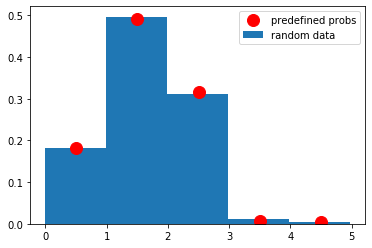

In [13]:
# 1. create an array of probabilities and samples
M = 10000 # number of samples to return in function
N = 5 # number of categories 
N_arr = np.arange(0,N,1) # an array of the categories *NOTE unnecessary?
p = np.zeros(N) # cdf pobability array, assembled below!
p_pdf = np.zeros(N) # pdf probability array
# assign values of p, and p_pdf
for pk in range(N):
    p_cum = p[pk-1]
    # check to see if it is the last iteration
    if pk == N-1:
        p[pk] = 1
        p_pdf[pk] = 1-p_cum
    else:
        p_pdf[pk] = np.random.uniform(0,1-p_cum)
        p[pk] = p_cum+p_pdf[pk]


# 2. make function sample(M,p), random number distribution
def random(M_in,p_cdf):
    output = np.zeros(M_in)
    for m in range(M_in): # loop through all elements in array
        p_in = np.random.uniform(0,1) # generate a random probability
        p_i = np.where(p_cdf >= p_in)[0][0] # extract first index of condition
        output[m] = np.random.uniform(p_i, p_i+1) # randomly generate a number in probability interview
    return output

output = random(M,p)

# 3. show results
fig, ax = plt.subplots(1, 1)
ax.plot(N_arr+0.5, p_pdf, 'ro', ms=12, mec='r', label='predefined probs')
ax.hist(output,density=True,bins=N,rwidth=1, label='random data')
plt.legend()
plt.show()

